# Project 1: Geometry
In this project, we will first delve deeper into geometry that underlies how camera images are formed and panorama stitching. In the end, you will also get to explore and have fun on your own with geometry and computer vision! 

_**Notes on Running This Notebook:**_

Make sure to run each part from its begining to ensure that you compute all of the dependencies of your current question and don't crossover variables with the same name from other questions. So long as you run each part from its beginning, you can run the parts in any order.

When assembling your PDF, we recommend running all cells in order from the top of the notebook to prevent any of these discontinuity errors.

## <font color='blue'>Part 1: Geometry & Camera (60 points)</font>

## 1.1 Transformations in 3D (27 points)

In order to make sense of how objects in our world are rendered in a camera, we typically need to understand how they are located relative to the camera. In this question, we'll examine some properties of the transformations that formalize this process by expressing coordinates with respect to multiple frames. 

We'll be considering a scene with two frames: a world frame ($W$) and a camera frame ($C$).

Notice that:
- We have 3D points $p$, $q$, $r$, and $s$ that define a square, which is parallel to the world $zy$ plane
- $C_z$ and $C_x$ belong to the plane defined by $W_z$ and $W_x$
- $C_y$ is parallel to $W_y$

<!-- into camera space as we translate a simple shape from world coordinates to camera coordinates. We will take this square in world coordinates and transform it into the camera coordinates.-->

<img src="part1/images/projection_geometry.png" alt="projection geometry figure" width="640" />

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def hash_numpy(x):
    import hashlib

    return hashlib.sha1(x.view(np.uint8)).hexdigest()


%load_ext autoreload
%autoreload 2

### 1.1 (a) Reference Frame Definitions (3 points)

First, let's take a moment to validate our understanding of 3D reference frames.

Consider creating:
- A point $w$ at the origin of the world frame ($O_w$)
- A point $c$ at the origin of the camera frame ($O_c$)

Examine the $x$, $y$, and $z$ axes of each frame, then express these points with respect to the world and camera frames. Fill in **`w_wrt_camera`**, **`w_wrt_world`**, and **`c_wrt_camera`**.

You can consider the length $d = 1$.

In [2]:
d = 1.0

# Abbreviation note:
# - "wrt" stands for "with respect to", which is ~synonymous with "relative to"

w_wrt_world = np.array([0.0, 0.0, 0.0])  # Done for you
w_wrt_camera = np.array([0.0, 0.0, d])  # Assign me!

c_wrt_world = np.array([d / np.sqrt(2), 0, d / np.sqrt(2)])   # Assign me!
c_wrt_camera = np.array([0.0, 0.0, 0.0])  # Assign me!

In [3]:
# Run this cell to check your answers!
assert (
    (3,)
    == w_wrt_world.shape
    == w_wrt_camera.shape
    == c_wrt_world.shape
    == c_wrt_camera.shape
), "Wrong shape!"
assert (
    hash_numpy(w_wrt_world) == "d3399b7262fb56cb9ed053d68db9291c410839c4"
), "Double check your w_wrt_world!"
assert (
    hash_numpy(w_wrt_camera) == "6248a1dcfe0c8822ba52527f68f7f98955584277"
), "Double check your w_wrt_camera!"
assert (
    hash_numpy(c_wrt_camera) == "d3399b7262fb56cb9ed053d68db9291c410839c4"
), "Double check your c_wrt_camera!"
assert (
    hash_numpy(c_wrt_world) == "a4c525cd853a072d96cade8b989a9eaf1e13ed3d"
), "Double check your c_wrt_world!"

print("Looks correct!")

Looks correct!


### 1.1 (b) World ⇨ Camera Transforms (15 points)

Derive the homogeneous transformation matrix needed to convert a point expressed with respect to the world frame $W$ in the camera frame $C$.

**Discuss the rotation and translation terms in this matrix and how you determined them, then implement it in `camera_from_world_transform()`** in `cameras.py` file.

We've also supplied a set of `assert` statements below to help you check your work.

---

*Hint #1:*
With rotation matrix $R \in \mathbb{R}^{3\times 3}$ and translation vector $t \in \mathbb{R}^{3\times 1}$, you can write transformations as $4 \times 4$ matrices: 
$$
\begin{bmatrix}{x_C} \\ {y_C} \\ {z_C} \\ 1\end{bmatrix} =
\begin{bmatrix}
    R & t \\
    \vec{0}^\top & 1
\end{bmatrix}
\begin{bmatrix}{x_W} \\ {y_W} \\ {z_W} \\ 1\end{bmatrix}
$$

*Hint #2: Remember our 2D transformation matrix for rotations in the $xy$ plane.*

$$\begin{bmatrix}{x}' \\ {y}'\end{bmatrix} = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta)\end{bmatrix} \begin{bmatrix}{x} \\ {y}\end{bmatrix}$$ 

To apply this to 3D rotations, you might think of this $xy$ plane rotation as holding the $z$ coordinate constant, since that's the axis you're rotating around, and transforming the $x$ and $y$ coordinates as described in the 2D formulation:

$$\begin{bmatrix}{x}' \\ {y}' \\ {z}'\end{bmatrix}  = \begin{bmatrix} \cos(\theta) & -\sin(\theta) & 0 \\ \sin(\theta) & \cos(\theta) & 0 \\ 0 & 0 & 1\end{bmatrix} \begin{bmatrix}{x} \\ {y} \\ {z}\end{bmatrix}$$

(Alternatively you could simply take the rotation matrix from the [Wikipedia](https://en.wikipedia.org/wiki/Rotation_matrix) page)

*Hint #3: In a homogeneous transform, the translation is applied after the rotation.*

As a result, you can visualize the translation as an offset in the output frame.

The order matters! You'll end up with a different transformation if you translate and then rotate versus if you rotate first and then translate with the same offsets. In lecture 2 we discussed a formulation for a combinated scaling, rotating, and translating matrix (in that order), which can be a useful starting point.

---

We notice that our first step must be a rotation of 135 degrees clockwise about the y axis, then we apply to translation of d units in the z direction. We can then combine these two steps into a single transformation matrix. 
\begin{bmatrix}
np.cos(np.pi*3/4) & 0 & np.sin(np.pi*3/4) & 0 \\
0 & 1 & 0 & 0 \\
-np.sin(np.pi*3/4) & 0 & np.cos(np.pi*3/4) & d \\   
0 & 0 & 0 & 1
\end{bmatrix}


In [4]:
# Check your answer against 1.1!
from part1.cameras import camera_from_world_transform

T_camera_from_world = camera_from_world_transform()

# Check c_wrt_camera against T_camera_from_world @ w_wrt_world
w_wrt_camera_computed = (T_camera_from_world @ np.append(w_wrt_world, 1.0))[:3]
print(f"w_wrt camera: expected {w_wrt_camera}, computed {w_wrt_camera_computed}")
assert np.allclose(
    w_wrt_camera, w_wrt_camera_computed
), "Error! (likely bad translation)"
print("Translation components look reasonable!")

# Check w_wrt_camera against T_camera_from_world @ c_wrt_world
c_wrt_camera_computed = (T_camera_from_world @ np.append(c_wrt_world, 1.0))[:3]
print(f"c_wrt camera: expected {c_wrt_camera}, computed {c_wrt_camera_computed}")
assert np.allclose(
    c_wrt_camera, c_wrt_camera_computed
), "Error! (likely bad rotation)"
print("Rotation components looks reasonable!")

w_wrt camera: expected [0. 0. 1.], computed [0. 0. 1.]
Translation components look reasonable!
c_wrt camera: expected [0. 0. 0.], computed [1.11022302e-16 0.00000000e+00 1.11022302e-16]
Rotation components looks reasonable!


### 1.1 (c) Preserving Edge Orientations (Geometric Intuition) (4 points)

Under the translation and rotation transformation from world coordinates to camera coordinates, which, if any, of the edges of the square retain their orientation and why? 

For those that change orientation, how do they change? (e.g. translation x,y,z and rotation in one of our planes). 

A sentence or two of geometric intuition is sufficient for each question, such as reasoning about the orientation of the edges and which axes we're rotating and translating about.

---

The edges that run parallel to the z axis will retain their orientation through the rotation and will be translated d units in the new z direction. All other axes will change orientation, being rotated 135 degrees clockwise about the y axis then translated d units in the new z direction.


### 1.1 (d) Visualization (5 points)

Implement **`apply_transform()`** to help us apply a homogeneous transformation to a batch of points.

Then, run the cell below to start visualizing our frames and the world square in PyPlot!

Using your code, we can animate a GIF that shows the transition of the square from its position in world coordinates to a new position in camera coordinates. We transform the perspective continuously from the world coordinate system to the camera coordinate system. Analogous to a homogeneous transform, you can see that we first rotate to match the orientation of the camera coordinate system, then translate to match the position of the camera origin. 

If you want to see how the animation was computed or if you want to play around with its configuration, then check out **`animate_transformation`** in **`utils.py`**!

..................................................................................

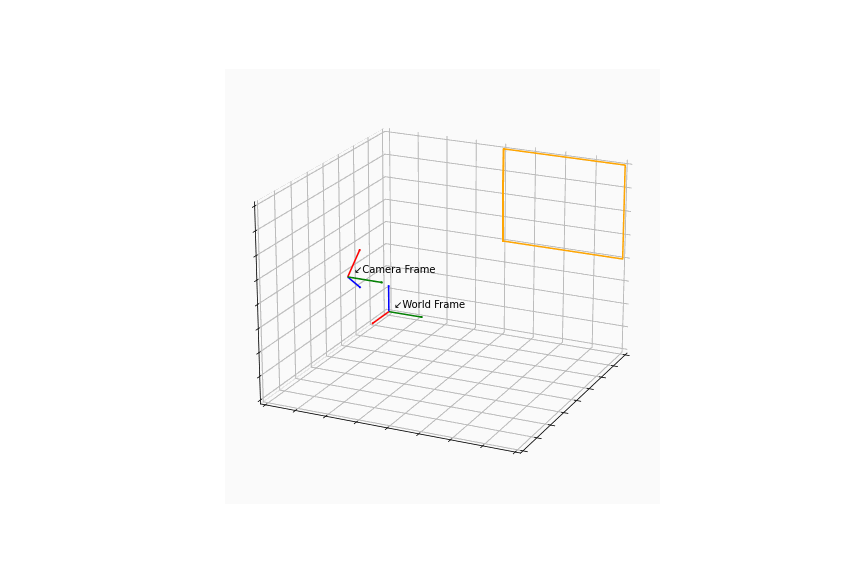

In [5]:
from part1.cameras import apply_transform
from part1.utils import (
    animate_transformation,
    configure_ax,
    plot_frame,
    plot_square,
)

# Vertices per side of the square
N = 2

# Compute vertices corresponding to each side of the square
vertices_wrt_world = np.concatenate(
    [
        np.vstack([np.zeros(N), np.linspace(1, 2, N), np.ones(N)]),
        np.vstack([np.zeros(N), np.ones(N) + 1, np.linspace(1, 2, N)]),
        np.vstack([np.zeros(N), np.linspace(2, 1, N), np.ones(N) + 1]),
        np.vstack([np.zeros(N), np.ones(N), np.linspace(1, 2, N)]),
    ],
    axis=1,
)

# Visualize our rotation!
animate_transformation(
    "transformation.gif",
    vertices_wrt_world,
    camera_from_world_transform,
    apply_transform,
)

import IPython.display

with open("transformation.gif", "rb") as file:
    display(IPython.display.Image(file.read()))

# Uncomment to compare to staff animation
# with open("part1/solution_transformation.gif", "rb") as file:
#     display(IPython.display.Image(file.read()))

## 1.2 Camera Intrinsics & Vanishing Points (12 points)

In a pinhole camera, lines that are parallel in 3D rarely remain parallel when projected to the image plane. Instead, parallel lines will meet at a **vanishing point**:

<img alt="vanishing point" src="part1/images/vanishing_point.jpg" width="600" />

### 1.2 (a) Homogeneous coordinates (6 points)

Consider a line that is parallel to a world-space direction vector in the set $\{ d \in \mathbb{R}^3 : d^\top d = 1\}$. Show that the image coordinates $v$ of the vanishing point can be be written as $v = KRd$.

*Hints:*
- As per the lecture slides, $K$ is the camera calibration matrix and $R$ is the camera extrinsic rotation.
- As in the diagram above, the further a point on a 3D line is from the camera origin, the closer its projection will be to the line's 2D vanishing point.
- Given a line with direction vector $d$, you can write a point that's infinitely far away from the camera via a limit: $\lim_{\alpha \to \infty} \alpha d$.
- The 3D homogeneous coordinate definition is:
$$
\begin{bmatrix}
    x & y & z & w
\end{bmatrix}^\top
\iff
\begin{bmatrix}
    x/w & y/w & z/w & 1
\end{bmatrix}^\top
$$


The homogenous representation of one of the lines that is parallel to the world-space direction vector and goes through the origin is $\begin{bmatrix} \cos(\alpha) \\ \cos(\beta) \\ \cos(\gamma) \\ 1/r \end{bmatrix}$, where $\alpha$, $\beta$, and $\gamma$ are the angles between the direction vector and the x, y, and z axes, respectively. As r goes to infinity, the image of the line goes to the vanishing point. Converting between world and image coordinate, we can see that
$$
\begin{align*}
v &= lim_{r \to \infty} \begin{bmatrix} K & 0 \end{bmatrix} \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix} \begin{bmatrix} \cos(\alpha) \\ \cos(\beta) \\ \cos(\gamma) \\ 1/r \end{bmatrix} \\
&= \begin{bmatrix} K & 0 \end{bmatrix} \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix} \begin{bmatrix} \cos(\alpha) \\ \cos(\beta) \\ \cos(\gamma) \\ 0 \end{bmatrix} \\
&= \begin{bmatrix} K & 0 \end{bmatrix}\begin{bmatrix} Rd \\0 \end{bmatrix} \\
&= KRd
\end{align*}
$$


---
_Note: Calibration from vanishing points_

_Let $d_0, d_1, \dots$ represent directional vectors for 3D lines in a scene, and $v_0, v_1, \dots$ represent their corresponding vanishing points._

_Consider the situtation when these lines are orthogonal:_
$$d_i^\top d_j = 0, \text{for each} i \neq j,$$
_then we also have_

$$
(K^{-1}v_i)^\top(K^{-1}v_j) = 0, \text{for each } i \neq j.
$$

### 1.2 (b) Short Response (6 points)

Respond to the following using bullet points:

- Assuming square pixels and no skew, how many vanishing points with mutually orthogonal directions do we now need to solve for our camera's focal length and optical center?

- Assuming square pixels and no skew, how many vanishing points with mutually orthogonal directions do we now need to solve for our camera's focal length when the optical center is known?


- Assuming square pixels and no skew, we need two vanishing points with mutually orthogonal directions to solve for our camera's focal length and optical center. 
- when the camera's optical center is known, we only need one vanishing point with mutually orthogonal directions to solve for the camera's focal length.


## 1.3 Intrinsic Calibration (41 points)

Using the vanishing point math from above, we can solve for a camera matrix $K$.

First, let's load in an image. To make life easier for you, we've hand labeled a set of coordinates on it that we'll use to compute vanishing points.

Image is 1300 x 975


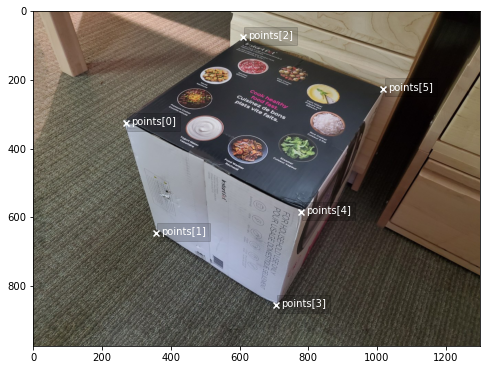

In [6]:
# Load image and annotated points; note that:
# > Our image is a PIL image type; you can convert this to NumPy with `np.asarray(img)`
# > Points are in (x, y) format, which corresponds to (col, row)!
img = Image.open("part1/images/pressure_cooker.jpg")
print(f"Image is {img.width} x {img.height}")
points = np.array(
    [
        [270.0, 327.0],  # [0]
        [356.0, 647.0],  # [1]
        [610.0, 76.0],  # [2]
        [706.0, 857.0],  # [3]
        [780.0, 585.0],  # [4]
        [1019.0, 226.0],  # [5]
    ]
)

# Visualize image & annotated points
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img)
ax.scatter(points[:, 0], points[:, 1], color="white", marker="x")
for i in range(len(points)):
    ax.annotate(
        f"points[{i}]",
        points[i] + np.array([15.0, 5.0]),
        color="white",
        backgroundcolor=(0, 0, 0, 0.15),
        zorder=0.1,
    )

### 1.3 (a) Finding Vanishing Points (10 points)

In 2D, notice that a vanishing point can be computing by finding the intersection of two lines that we know are parallel in 3D.

To find the vanishing points in the image, implement **`intersection_from_lines()`**.

Then, run the cell below to check that it's working.

Note that later parts of this homework will fail if you choose the side face instead of the front face for producing the leftmost vanishing point.

In [7]:
from part1.cameras import intersection_from_lines

# Python trivia: the following two assert statements are the same.
# > https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists
# > https://numpy.org/doc/stable/reference/arrays.indexing.html#integer-array-indexing
assert np.allclose(
    intersection_from_lines(points[0], points[1], points[4], points[0],),
    points[0],
)
assert np.allclose(intersection_from_lines(*points[[0, 1, 4, 0]]), points[0])
print("Looks correct!")

Looks correct!


To use the constraint we derived above, we need to find vanishing points that correspond to three orthogonal direction vectors.

Populate `v0_indices`, `v1_indices`, and `v2_indices`, then run the cell below to compute `v`.

You should be able to get an output that looks like this (color ordering does not matter):

![vanishing point reference](part1/images/vanishing_point_reference.png)

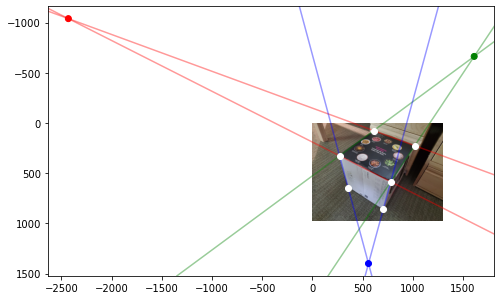

In [8]:
# Select points used to compute each vanishing point
#
# Each `v*_indices` list should contain four integers, corresponding to
# indices into the `points` array; the first two ints define one line and
# the second two define another line.
v0_indices = None
v1_indices = None
v2_indices = None

### YOUR CODE HERE
v0_indices = [0, 4, 2, 5]
v1_indices = [0, 2, 4, 5]
v2_indices = [0, 1, 3, 4]
### END YOUR CODE

# Validate indices
assert (
    len(v0_indices) == len(v1_indices) == len(v2_indices) == 4
), "Invalid length!"
for i, j, k in zip(v0_indices, v1_indices, v2_indices):
    assert type(i) == type(j) == type(k) == int, "Invalid type!"

# Compute vanishing points
v = np.zeros((3, 2))
v[:, :2] = np.array(
    [
        intersection_from_lines(*points[v0_indices]),
        intersection_from_lines(*points[v1_indices]),
        intersection_from_lines(*points[v2_indices]),
    ]
)
assert v.shape == (3, 2)

# Display image
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img)

# Display annotated points
ax.scatter(points[:, 0], points[:, 1], color="white")

# Visualize vanishing points
colors = ["red", "green", "blue"]
for indices, color in zip((v0_indices, v1_indices, v2_indices), colors):
    ax.axline(*points[indices[:2]], zorder=0.1, c=color, alpha=0.4)
    ax.axline(*points[indices[2:]], zorder=0.1, c=color, alpha=0.4)
ax.scatter(v[:, 0], v[:, 1], c=colors)

pass

### 1.3 (b) Computing Optical Centers (10 points)

Next, implement **`optical_center_from_vanishing_points()`** to compute the 2D optical center from our vanishing points. Then, run the cell below to compute a set of optical center coordinates from our vanishing points.

*Hint:* Property 3 from [1] may be useful. (Try connecting to Stanford campus network otherwise the paper link might not work for you.)
> [1] Caprile, B., Torre, V. **Using vanishing points for camera calibration.** *Int J Comput Vision 4, 127–139 (1990)*. https://doi.org/10.1007/BF00127813

Looks correct!


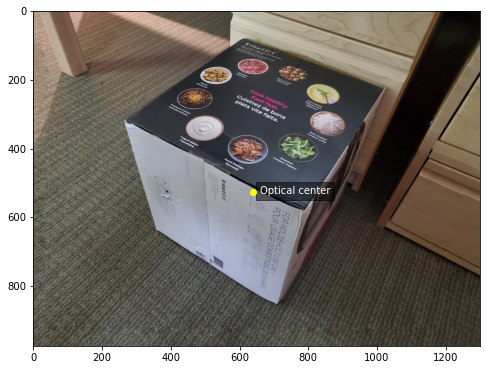

In [9]:
from part1.cameras import optical_center_from_vanishing_points

optical_center = optical_center_from_vanishing_points(v[0], v[1], v[2],)

assert np.allclose(np.mean(optical_center), 583.4127277436276)
assert np.allclose(np.mean(optical_center ** 2), 343524.39942528843)
print("Looks correct!")

# Display image
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img)

# Display optical center
ax.scatter(*optical_center, color="yellow")
ax.annotate(
    "Optical center",
    optical_center + np.array([20, 5]),
    color="white",
    backgroundcolor=(0, 0, 0, 0.5),
    zorder=0.1,
)

pass

### 1.3 (c) Computing Focal Lengths (10 points)

Consider two vanishing points corresponding to orthogonal directions, and the constraint from above:

$$
(K^{-1}v_0)^\top(K^{-1}v_1) = 0, \text{for each } i \neq j
$$

Derive an expression for computing the focal length when the optical center is known, then implement **`focal_length_from_two_vanishing_points()`**.

When we assume square pixels and no skew, recall that the intrinsic matrix $K$ is:

$$
K = \begin{bmatrix}
    f & 0 & c_x \\
    0 & f & c_y \\
    0 & 0 & 1 \\
\end{bmatrix}
$$

*Hint:* Optional, but this problem maybe be simpler if you factorize $K$ as:

$$
K = \begin{bmatrix}
    1 & 0 & c_x \\
    0 & 1 & c_y \\
    0 & 0 & 1 \\
\end{bmatrix}\begin{bmatrix}
    f & 0 & 0 \\
    0 & f & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
$$

When working with homogeneous coordinates, note that the lefthand matrix is a simple translation.



In [10]:
from part1.cameras import focal_length_from_two_vanishing_points

# If your implementation is correct, these should all be ~the same
f = focal_length_from_two_vanishing_points(v[0], v[1], optical_center)
print(f"Focal length from v0, v1: {f}")
f = focal_length_from_two_vanishing_points(v[1], v[2], optical_center)
print(f"Focal length from v1, v2: {f}")
f = focal_length_from_two_vanishing_points(v[0], v[2], optical_center)
print(f"Focal length from v0, v2: {f}")

Focal length from v0, v1: 1056.9925197083348
Focal length from v1, v2: 1056.992519708452
Focal length from v0, v2: 1056.9925197084528


### 1.3 (d) Comparison to EXIF data (5 points)

To validate our focal length computation, one smoke test we can run is compare it to parameters supplied by the camera manufacturer.

In JPEG images, these parameters and other metadata are sometimes stored using [EXIF](https://en.wikipedia.org/wiki/Exif) tags that are written when the photo is taken. Run the cell below to read & print some of this using the Python Imaging Library!

In [11]:
from PIL.ExifTags import TAGS

# Grab EXIF data
exif = {TAGS[key]: value for key, value in img._getexif().items()}

# Print subset of keys
print(f"EXIF data for {img.filename}\n=====")
for key in (
    "DateTimeOriginal",
    "FocalLength",
    "GPSInfo",
    "Make",
    "Model",
):
    print(key.ljust(25), exif[key])

EXIF data for part1/images/pressure_cooker.jpg
=====
DateTimeOriginal          2020:11:06 01:02:20
FocalLength               4.3
GPSInfo                   {1: 'N', 2: (37.0, 25.0, 29.903), 3: 'W', 4: (122.0, 9.0, 34.294), 5: b'\x00', 6: 0.0}
Make                      samsung
Model                     SM-G970U


From above, we see that the focal length of our camera system is **`4.3mm`**.

Focal lengths are typically in millimeters, but all of the coordinates we've worked with thus far have been in pixel-space. Thus, we first need to convert our focal length from pixels to millimeters.

Try to visualize this conversion, then implement **`physical_focal_length_from_calibration()`**.

In [12]:
from part1.cameras import physical_focal_length_from_calibration

# Length across sensor diagonal for SM-G970U (Galaxy S10e)
# > https://en.wikipedia.org/wiki/Samsung_CMOS
sensor_diagonal_mm = 7.06

# Length across image diagonal
image_diagonal_pixels = np.sqrt(img.width ** 2 + img.height ** 2)

f_mm = physical_focal_length_from_calibration(
    f, sensor_diagonal_mm, image_diagonal_pixels,
)
print(f"Computed focal length:".ljust(30), f_mm)

error = np.abs(f_mm - 4.3) / 4.3
print("Calibration vs spec error:".ljust(30), f"{error * 100:.2f}%")
assert 0.06 < error < 0.07

Computed focal length:         4.592225962548724
Calibration vs spec error:     6.80%


### 1.3 (e) Analysis (6 points)

If everything went smoothly, your computed focal length should only deviate from the manufacturer spec by ~6.8%.

Aside from manufacturing tolerances, name two or more other possible causes for this error, then discuss the limitations of this calibration method.

This calibration method needs three vanishing points to all estimated accurately and be orthogonal to each other. However, in practice, it is difficult to find them, especially because the vanishing points are sensitive to the noise in the image. This method also assumes that the camera has square pixels and no skew, which is not always the case.


## <font color='blue'>Part 2: Panorama Stitching (70 points)</font>


**Introduction:**

Panorama stitching is an early success of computer vision. Matthew Brown and David G. Lowe published a famous [panoramic image stitching paper](http://matthewalunbrown.com/papers/ijcv2007.pdf) in 2007. Since then, automatic panorama stitching technology has been widely adopted in many applications such as Google Street View, panorama photos on smartphones,
and stitching software such as Photosynth and AutoStitch.

In this part of the project, we will detect and match keypoints from multiple images to build a single panoramic image. This will involve several tasks:
1. Compare two sets of descriptors coming from two different images and find matching keypoints.
2. Given a list of matching keypoints, use the least-squares method to find the affine transformation matrix that maps points in one image to another.
3. Use RANSAC to give a more robust estimate of the affine transformation matrix. <br>
   Given the transformation matrix, use it to transform the second image and overlay it on the first image, forming a panorama.
4. Blend panorama images together to remove blurry regions of overlapping images.
5. Stich multiple panorama images together.


In [13]:
from __future__ import print_function

# Setup
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import matplotlib.pyplot as plt
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2.1 Matching Keypoints (10 points)

You are given a set of keypoints in two images (obtained by running the Harris corner detector). The question we want to answer is: How can we determine which pairs of keypoints come from the same 3D points projected on the two different images? In order to *match* the detected keypoints, we must come up with a way to *describe* the keypoints based on their local appearance. Generally, each region around detected keypoint locations is converted into  a fixed-size vector called a *descriptor*. 

We have implemented a simple descriptor function for you, where each keypoint is described by the normalized intensity of a small patch around it.

Keypoints 1 shape =  (397, 2)
Keypoints 2 shape =  (629, 2)


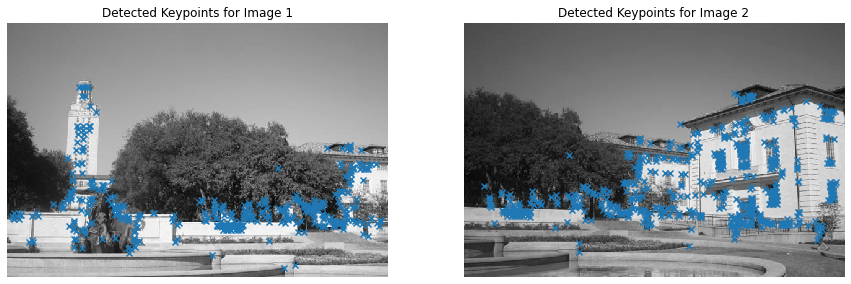

In [14]:
from part2.panorama import harris_corners

img1 = imread('part2/uttower1.jpg', as_gray=True)
img2 = imread('part2/uttower2.jpg', as_gray=True)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

print("Keypoints 1 shape = ", keypoints1.shape)
print("Keypoints 2 shape = ", keypoints2.shape)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()

Implement the **`match_descriptors`** function to find good matches in two sets of descriptors. First, calculate Euclidean distance between all pairs of descriptors from image 1 and image 2. Then use this to determine if there is a good match: for each descriptor in image 1, if the distance to the closest descriptor in image 2 is significantly (by a given factor) smaller than the distance to the second-closest, we call it a match. The output of the function is an array where each row holds the indices of one pair of matching descriptors.

*Checking your answer*: you should see an identical matching of keypoints as the solution, but the precise colors of each line will change with every run of keypoint matching so colors do not need to match.

*Optional ungraded food for thought*: Think about why this method of keypoint matching is not commutative.

Desc1 shape =  (397, 25)
Desc2 shape =  (629, 25)


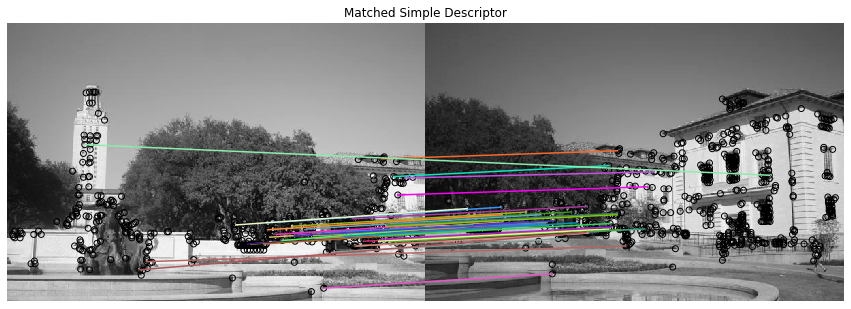

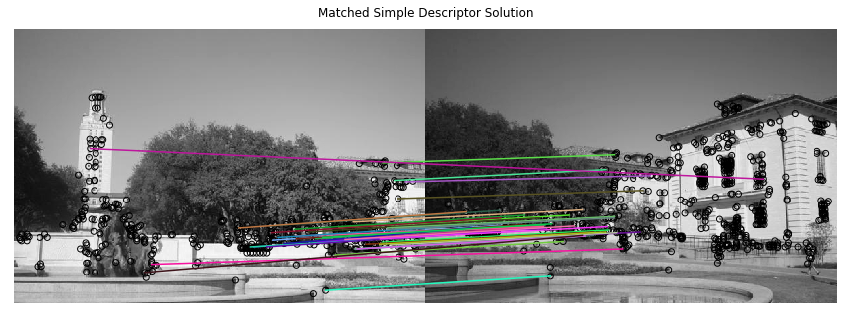

In [15]:
from part2.panorama import simple_descriptor, match_descriptors, describe_keypoints
from part2.utils import plot_matches

# Set seed to compare output against solution
np.random.seed(131)

patch_size = 5
    
# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

print("Desc1 shape = ", desc1.shape)
print("Desc2 shape = ", desc2.shape)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plt.title('Matched Simple Descriptor')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()

plt.imshow(imread('part2/solution_simple_descriptor.png'))
plt.axis('off')
plt.title('Matched Simple Descriptor Solution')
plt.show()

### 2.2 Transformation Estimation (20 points)

We now have a list of matched keypoints across the two images. We will use this to find a transformation matrix that maps points in the second image to the corresponding coordinates in the first image. In other words, if the point $p_1 = [y_1,x_1]$ in image 1 matches with $p_2=[y_2, x_2]$ in image 2, we need to find an affine transformation matrix $H$ such that

$$
\tilde{p_2}H = \tilde{p_1},
$$

where $\tilde{p_1}$ and $\tilde{p_2}$ are homogenous coordinates of $p_1$ and $p_2$.

Note that it may be impossible to find the transformation $H$ that maps every point in image 2 exactly to the corresponding point in image 1. However, we can estimate the transformation matrix with least squares. Given $N$ matched keypoint pairs, let $X_1$ and $X_2$ be $N \times 3$ matrices whose rows are homogenous coordinates of corresponding keypoints in image 1 and image 2 respectively. Then, we can estimate $H$ by solving the least squares problem,

$$
X_2 H = X_1
$$

Implement **`fit_affine_matrix`** in `panorama.py`

*-Hint: read the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) about np.linalg.lstsq*

In [16]:
from part2.panorama import fit_affine_matrix

# Sanity check for fit_affine_matrix

# Test inputs
a = np.array([[0.5, 0.1], [0.4, 0.2], [0.8, 0.2]])
b = np.array([[0.3, -0.2], [-0.4, -0.9], [0.1, 0.1]])

H = fit_affine_matrix(b, a)

# Target output
sol = np.array(
    [[1.25, 2.5, 0.0],
     [-5.75, -4.5, 0.0],
     [0.25, -1.0, 1.0]]
)

error = np.sum((H - sol) ** 2)

if error < 1e-20:
    print('Implementation correct!')
else:
    print('There is something wrong.')

Implementation correct!


After checking that your `fit_affine_matrix` function is running correctly, run the following code to apply it to images.
Images will be warped and image 2 will be mapped to image 1.

Output shape: [496 615]
Offset: [-39.37184617   0.        ]


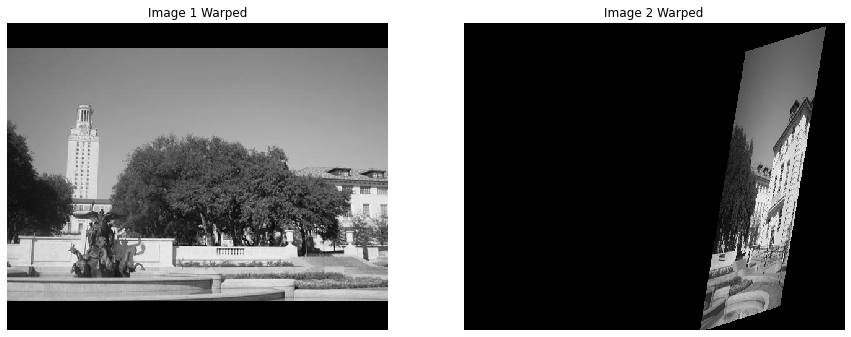

In [17]:
from part2.utils import get_output_space, warp_image

# Extract matched keypoints
p1 = keypoints1[matches[:,0]]
p2 = keypoints2[matches[:,1]]

# Find affine transformation matrix H that maps p2 to p1
H = fit_affine_matrix(p1, p2)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)


# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 Warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 Warped')
plt.axis('off')

plt.show()

Next, the two warped images are merged to get a panorama. Your panorama may not look good at this point, but we will later use other techniques to get a better result.

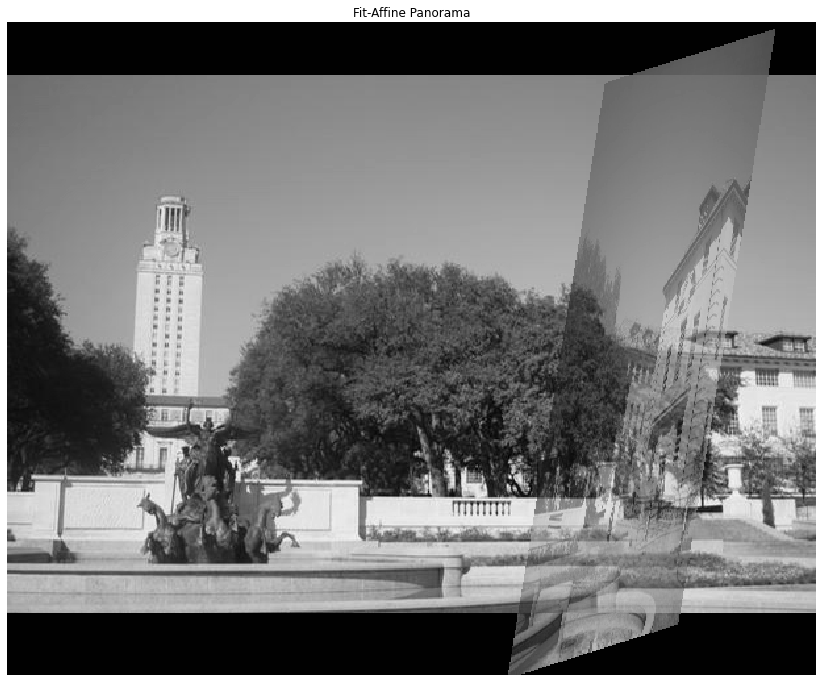

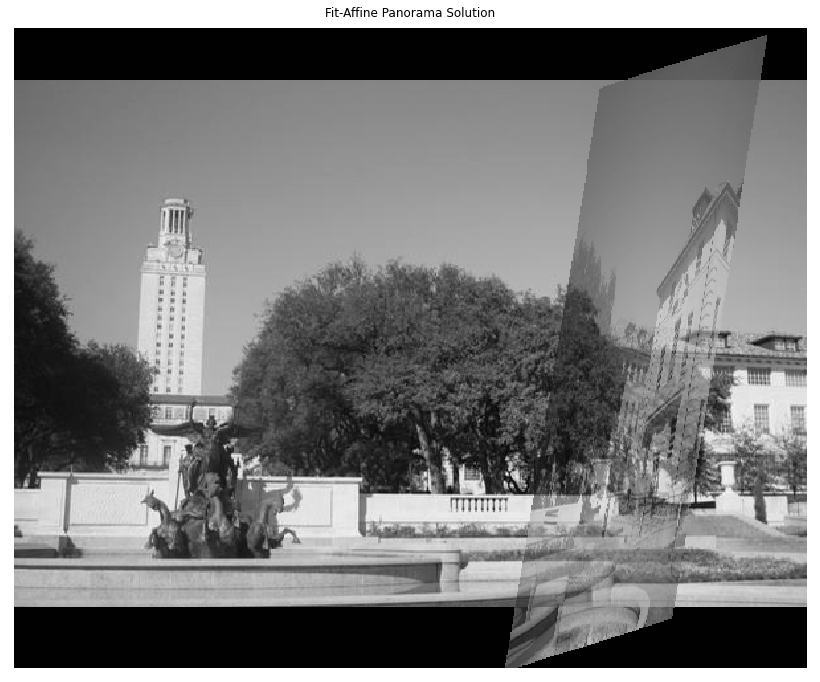

In [18]:
# Merge the two images
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

plt.imshow(normalized)
plt.axis('off')
plt.title('Fit-Affine Panorama')
plt.show()

plt.imshow(imread('part2/solution_fit_affine_panorama.png'))
plt.axis('off')
plt.title('Fit-Affine Panorama Solution')
plt.show()

### 2.3 RANSAC (20 points)
Rather than directly feeding all our keypoint matches into ``fit_affine_matrix`` function, we can instead use RANSAC ("RANdom SAmple Consensus") to select only "inliers" to use for computing the transformation matrix.

The steps of RANSAC are:
1. Select random set of matches
2. Compute affine transformation matrix
3. Find inliers using the given threshold
4. Repeat and keep the largest set of inliers (use >, i.e. break ties by whichever set is seen first)
5. Re-compute least-squares estimate on all of the inliers
    
In this case, use Euclidean distance between matched points as a measure of inliers vs outliers.

Implement **`ransac`** in `panorama.py`, run through the following code to get a panorama. You can see the difference from the result we get without RANSAC.

Robust matches shape =  (15, 2)
H = 
 [[ 1.01547911e+00 -2.05403127e-02  0.00000000e+00]
 [-2.95442562e-02  1.02607916e+00  0.00000000e+00]
 [ 2.12738722e+01  2.74454931e+02  1.00000000e+00]]


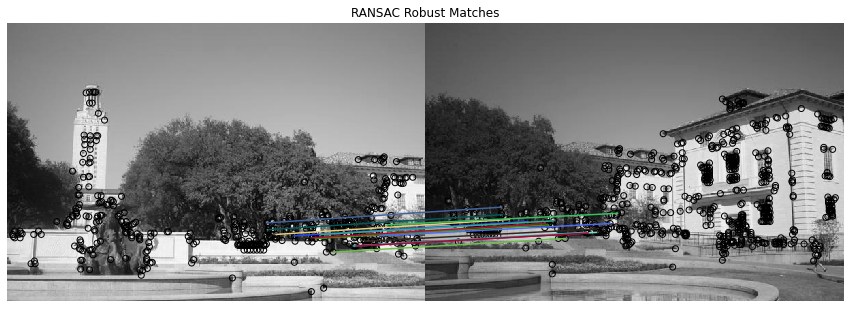

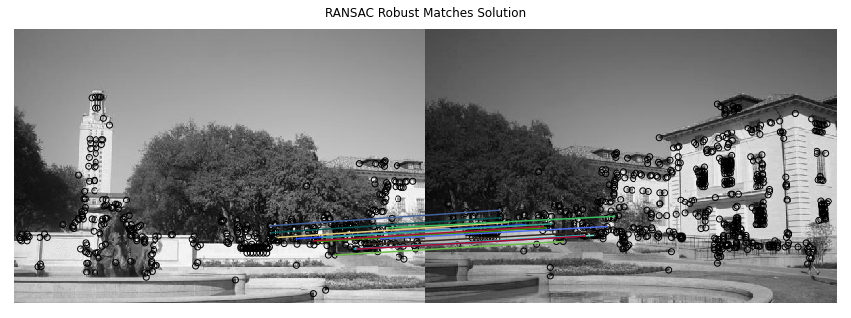

In [19]:
from part2.panorama import ransac

# Set seed to compare output against solution image
np.random.seed(131)

H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)
print("Robust matches shape = ", robust_matches.shape)
print("H = \n", H)

# Visualize robust matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.title('RANSAC Robust Matches')
plt.show()

plt.imshow(imread('part2/solution_ransac.png'))
plt.axis('off')
plt.title('RANSAC Robust Matches Solution')
plt.show()

We can now use the tranformation matrix $H$ computed using the robust matches to warp our images and create a better-looking panorama.

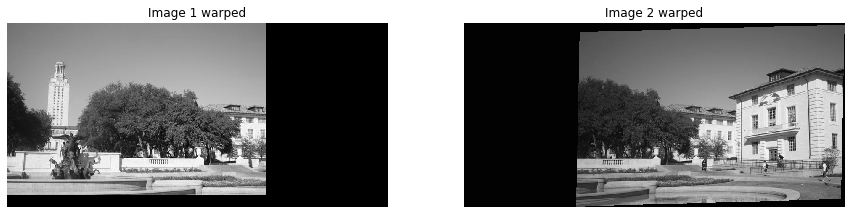

In [20]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

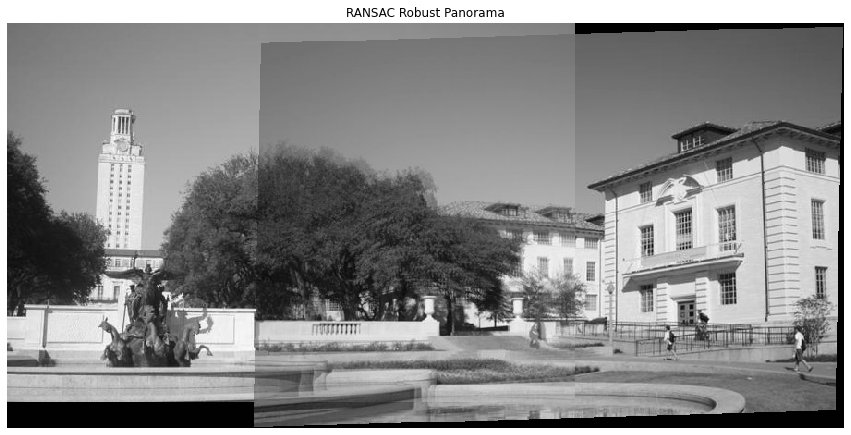

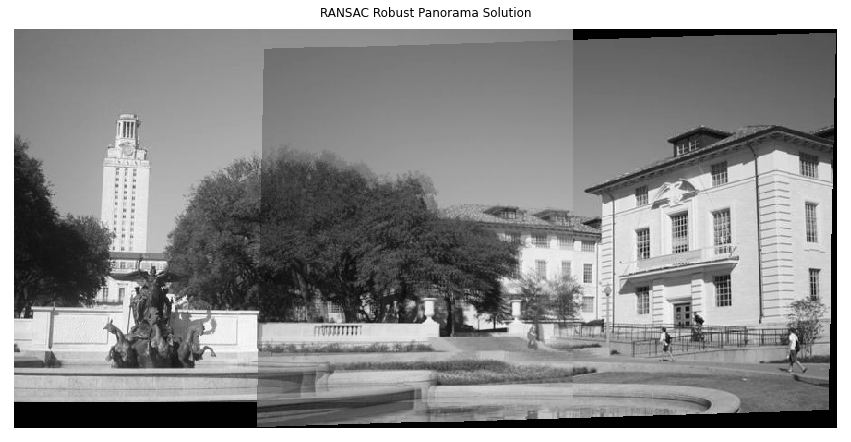

In [21]:
# Merge the two images
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.title('RANSAC Robust Panorama')
plt.show()

plt.imshow(imread('part2/solution_ransac_panorama.png'))
plt.axis('off')
plt.title('RANSAC Robust Panorama Solution')
plt.show()

### 2.4 Better Image Merging (10 points)
You will notice the blurry region and unpleasant lines in the middle of the final panoramic image. Using a very simple technique called linear blending, we can smooth out a lot of these artifacts from the panorama.

Currently, all the pixels in the overlapping region are weighted equally. However, since the pixels at the left and right ends of the overlap are very well complemented by the pixels in the other image, they can be made to contribute less to the final panorama.

Linear blending can be done with the following steps:
    1. Define left and right margins for blending to occur between
    2. Define a weight matrix for image 1 such that:
        - From the left of the output space to the left margin the weight is 1
        - From the left margin to the right margin, the weight linearly decrements from 1 to 0
    3. Define a weight matrix for image 2 such that:
        - From the right of the output space to the right margin the weight is 1
        - From the left margin to the right margin, the weight linearly increments from 0 to 1
    4. Apply the weight matrices to their corresponding images
    5. Combine the images 

In **`linear_blend`** in `panorama.py` implement the linear blending scheme to make the panorama look more natural.

EC1 keypoints1 shape =  (397, 2)
EC1 keypoints2 shape =  (629, 2)
EC1 desc1 shape =  (397, 256)
EC1 desc2 shape =  (629, 256)
Robust matches shape =  (45, 2)
H = 
 [[ 1.03962934e+00  6.35346948e-02  0.00000000e+00]
 [-2.84557715e-02  1.03751684e+00  0.00000000e+00]
 [ 1.37580085e+01  2.46819754e+02  1.00000000e+00]]
Output shape: [444 911]
Offset: [-3.74229102  0.        ]


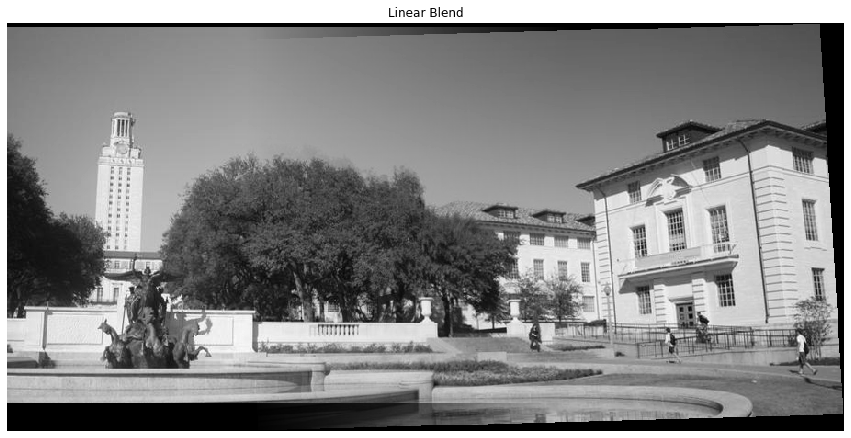

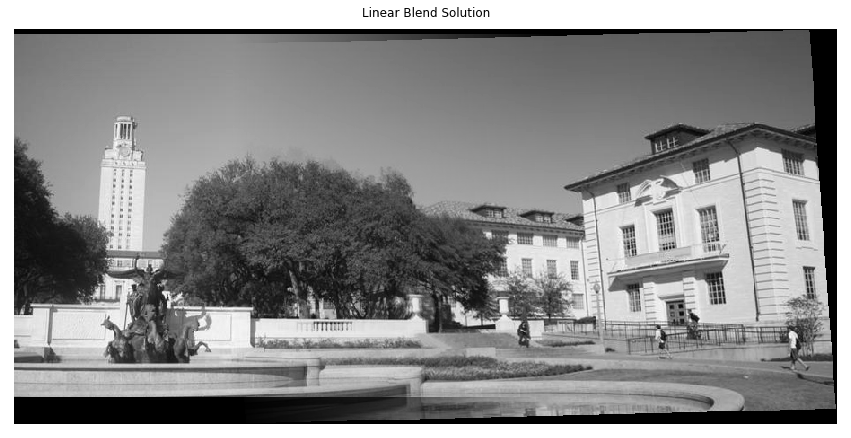

In [22]:
from part2.panorama import linear_blend

img1 = imread('part2/uttower1.jpg', as_gray=True)
img2 = imread('part2/uttower2.jpg', as_gray=True)

# Set seed to compare output against solution
np.random.seed(131)

# Detect keypoints in both images
ec1_keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                              threshold_rel=0.05,
                              exclude_border=8)
ec1_keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                              threshold_rel=0.05,
                              exclude_border=8)

print("EC1 keypoints1 shape = ", ec1_keypoints1.shape)
print("EC1 keypoints2 shape = ", ec1_keypoints2.shape)

# Extract features from the corners
ec1_desc1 = describe_keypoints(img1, ec1_keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=16)
ec1_desc2 = describe_keypoints(img2, ec1_keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=16)

print("EC1 desc1 shape = ", ec1_desc1.shape)
print("EC1 desc2 shape = ", ec1_desc2.shape)

# Match descriptors in image1 to those in image2
ec1_matches = match_descriptors(ec1_desc1, ec1_desc2, 0.7)

H, robust_matches = ransac(ec1_keypoints1, ec1_keypoints2, ec1_matches, threshold=1)
print("Robust matches shape = ", robust_matches.shape)
print("H = \n", H)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Merge the warped images using linear blending scheme
merged = linear_blend(img1_warped, img2_warped)

plt.imshow(merged)
plt.axis('off')
plt.title('Linear Blend')
plt.show()

plt.imshow(imread('part2/solution_linear_blend.png'))
plt.axis('off')
plt.title('Linear Blend Solution')
plt.show()

### 2.5 Stitching Multiple Images (10 points)
Implement **`stitch_multiple_images`** in `panorama.py` to stitch together an ordered chain of images.

Given a sequence of $m$ images ($I_1, I_2,...,I_m$), take every neighboring pair of images and compute the transformation matrix which converts points from the coordinate frame of $I_{i+1}$ to the frame of $I_{i}$. Then, select a reference image $I_{ref}$, which is the first or left-most image in the chain. We want our final panorama image to be in the coordinate frame of $I_{ref}$.

You do **not** need to use linear blending for this problem: it's not included in the solution so the autograder does not expect it.

*-Hint:*
- If you are confused, you may want to review the Linear Algebra slides on how to combine the effects of multiple transformation matrices.
- The inverse of transformation matrix has the reverse effect. Please use [`numpy.linalg.inv`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) function whenever you want to compute matrix inverse.

In [23]:
from part2.panorama import stitch_multiple_images

# Set seed to compare output against solution
np.random.seed(131)

# Load images to be stitched
ec2_img1 = imread('part2/yosemite1.jpg', as_gray=True)
ec2_img2 = imread('part2/yosemite2.jpg', as_gray=True)
ec2_img3 = imread('part2/yosemite3.jpg', as_gray=True)
ec2_img4 = imread('part2/yosemite4.jpg', as_gray=True)

imgs = [ec2_img1, ec2_img2, ec2_img3, ec2_img4]

# Stitch images together
panorama = stitch_multiple_images(imgs, desc_func=simple_descriptor, patch_size=5)


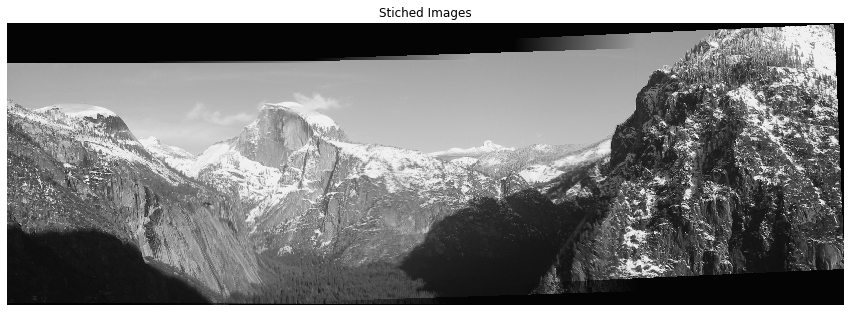

In [24]:
# Visualize final panorama image
plt.imshow(panorama)
plt.axis('off')
plt.title('Stiched Images')
plt.show()

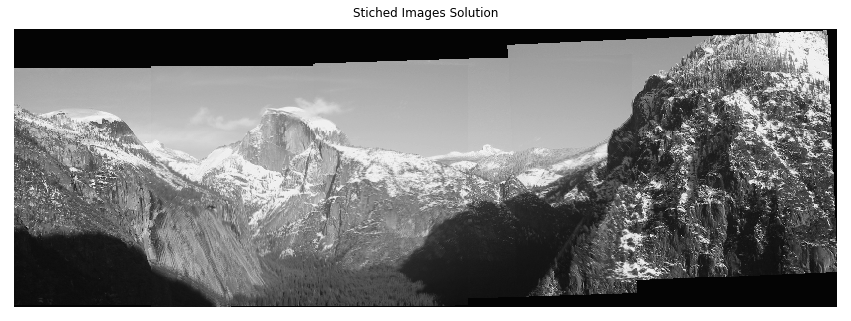

In [25]:
plt.imshow(imread('part2/solution_stitched_images.png'))
plt.axis('off')
plt.title('Stiched Images Solution')
plt.show()

## <font color='blue'>Part 3: Exploration (15 points) </font>
We’ve explored some of the basic approaches in geometry, now it is your turn to explore on your own! The goal here is to get you started working on using CV on your own. We’ve provided a list of resources and topic suggestions for inspiration and starting point, but feel free to deviate towards your interests!

**Libraries:**

Feel free to explore the following libraries and use functions that are helpful for your choice of exploration.
- [OpenCV](https://opencv.org/): Provides a wide range of functionalities for real-time computer vision, such as image processing, video capture, and object detection, making it ideal for projects involving visual data analysis.
- [Kornia](https://kornia.github.io/): A differentiable computer vision library for PyTorch, consists of a set of routines and differentiable modules to solve generic computer vision problems.
- [Pytorch 3D](https://pytorch3d.org/): An extension of PyTorch designed for 3D data processing.

**Exploration Idea Inspirations:**

Check out bonus slides from lecture 4: Pinhole Camera Model for more details on the ideas.

- Monocular 3D: do we see with our eyes or brain?
- Other Camera Models: peek beyond the pinhole
- Lenses: shining some light on this important piece
- Vanishing Points++: infinitely more to reveal!
- Calibration++: multi-plane, distortion, vanishing points 
- Single View Metrology: measure things from 2D


**_We encourage you to start early on this part, and stop by OH if you have questions regarding your exploration idea and implementation._**

_This section is intentionally open-ended, and any honest efforts towards exploration will be awarded full credit, with exceptional projects can receiving up to 3% extra credit. We encourage you to use other libraries and available resources on the internet (please do!), but please cite and external resources that you reference._



### Deliverables
#### Write-up: 
A brief explanation of what you explored, how you went about implementing it, and how it relates to geometry. Please attach any images, figures, etc. If your writeup is long or includes many images/figures/equations, you may also upload to drive and include a link to your work. Please also explicitly cite your sources in the write-up.

I wanted to explore OpenCV, as it seemed to have many powerful tools for computer vision that I had not yet explored. Specifically, I used the Canny edge detection algorithm to detect edges in an image. Then, I found and drew the contours overlaid on the original image. This relates to geometry because the contours are the edges of the objects in the image, and the Canny edge detection algorithm is a way to find these edges. This helpful in many practical contexts, such as object detection and image segmentation, but also in the artistic sense, as it can be used to create interesting effects in images (existing filters that "sketchify" an image are often based on edge detection). The example I used of kermit becomes drawn in contour lines. 


#### Code:
Please include any code that you wrote here. If your code contains other files, please make sure to also include them in the submission. If you have a lot of code, you may also upload to drive and include a link to your work.

If you choose to do a mathematical proof or calculation, no need for code. Please specify and state so explicitly. 


In [ ]:
import cv2

image = cv2.imread('part2/kermit.jpg', cv2.IMREAD_GRAYSCALE)

# find Canny edges
edged = cv2.Canny(image, 30, 200)

# find and draw contours
contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(image, contours, -1, (50, 0, 50), 2)

cv2.imwrite('part2/kermitafter.png', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

print(f"Number of contours found: {len(contours)}")

plt.imshow(imread('part2/kermit.jpg'))
plt.imshow(imread('part2/kermitafter.png'))